https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

Examples include:
* ECG signals - voltage vs time and normal vs. abnormal
* Motion sensor data

## Indoor User Movement Prediction
We will be working on the ‘Indoor User Movement Prediction‘ problem. In this challenge, multiple motion sensors are placed in different rooms and the goal is to identify whether an individual has moved across rooms, based on the frequency data captured from these motion sensors. 

There are four motion sensors (A1, A2, A3, A4) placed across two rooms. Have a look at the below image which illustrates where the sensors are positioned in each room. The setup in these two rooms was created in 3 different pairs of rooms (group1, group2, group3).

In [1]:
from IPython.display import Image

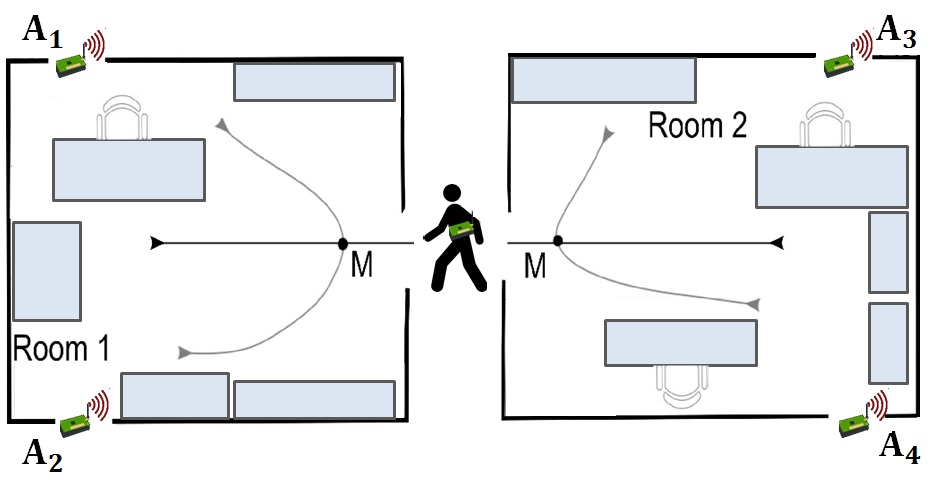

In [2]:
Image("https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/12/MovementAAL.jpg")

A person can move along any of the six pre-defined paths shown in the above image. If a person walks on path 2, 3, 4 or 6, he moves within the room. On the other hand, if a person follows path 1 or path 5, we can say that the person has moved between the rooms.

The sensor reading can be used to identify the position of a person at a given point in time. As the person moves in the room or across rooms, the reading in the sensor changes. This change can be used to identify the path of the person.

You can download the dataset from this link: [Indoor User Movement Prediction](https://archive.ics.uci.edu/ml/datasets/Indoor+User+Movement+Prediction+from+RSS+data)

Our dataset comprises of 316 files:

* 314 `MovementAAL` csv files containing the readings from motion sensors placed in the environment
* A `Target` csv file that contains the target variable for each `MovementAAL` file
* One `Group Data` csv file to identify which `MovementAAL` file belongs to which setup group
* The Path csv file that contains the path which the object took

Let’s have a look at the datasets. We’ll start by importing the necessary libraries.

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [4]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [25]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence

## EDA

In [6]:
df1 = pd.read_csv('MovementAAL/dataset/MovementAAL_RSS_1.csv')
df2 = pd.read_csv('MovementAAL/dataset/MovementAAL_RSS_2.csv')

In [7]:
df1.head()

,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


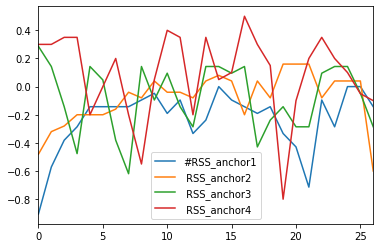

In [9]:
df1.plot()

In [11]:
df1.shape, df2.shape

((27, 4), (26, 4))

The files contain normalized data from the four sensors – A1, A2, A3, A4. The length of the csv files (number of rows) vary, since the data corresponding to each csv is for a different duration. To simplify things, let us suppose the sensor data is collected every second. The first reading was for a duration of 27 seconds (so 27 rows), while another reading was for 26 seconds (so 26 rows).

We will have to deal with this varying length before we build our model. For now, we will read and store the values from the sensors in a list using the following code block:

In [13]:
path = 'MovementAAL/dataset/MovementAAL_RSS_'
sequences = list()
for i in range(1,315):
    file_path = path + str(i) + '.csv'
    # print(file_path)
    df = pd.read_csv(file_path, header=0)
    values = df.values
    sequences.append(values)

When we print sequences[0], we get the values of sensors from the first csv file:

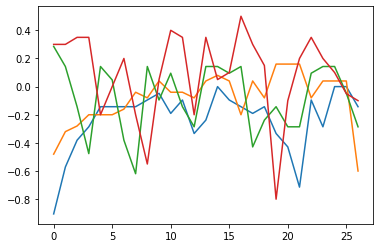

In [19]:
plt.plot(sequences[0]);

the goal (`target`) is to identify whether an individual has moved across rooms, based on the frequency data captured from these motion sensors.

In [14]:
targets = pd.read_csv('MovementAAL/dataset/MovementAAL_target.csv')
targets = targets.values[:,1]

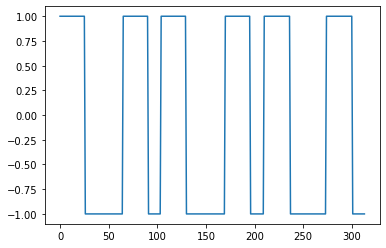

In [17]:
plt.plot(targets)

As mentioned previously, the dataset was collected in three different pairs of rooms – hence three groups. This information can be used to divide the dataset into train, test and validation sets. We will load the DatasetGroup csv file now:

In [20]:
groups = pd.read_csv('MovementAAL/groups/MovementAAL_DatasetGroup.csv', header=0)
groups = groups.values[:,1]

(array([104.,   0.,   0.,   0.,   0., 106.,   0.,   0.,   0., 104.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

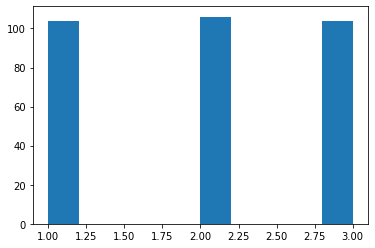

In [22]:
plt.hist(groups)

We will take the data from the first two sets for training purposes and the third group for testing.

## Preprocessing Steps
Since the time series data is of varying length, we cannot directly build a model on this dataset. So how can we decide the ideal length of a series? There are multiple ways in which we can deal with it and here are a few ideas (I would love to hear your suggestions in the comment section):

Pad the shorter sequences with zeros to make the length of all the series equal. In this case, we will be feeding incorrect data to the model
Find the maximum length of the series and pad the sequence with the data in the last row
Identify the minimum length of the series in the dataset and truncate all the other series to that length. However, this will result in a huge loss of data
Take the mean of all the lengths, truncate the longer series, and pad the series which are shorter than the mean length
Let’s find out the minimum, maximum and mean length:

In [23]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    314.000000
mean      42.028662
std       16.185303
min       19.000000
25%       26.000000
50%       41.000000
75%       56.000000
max      129.000000
dtype: float64

Most of the files have lengths between 40 to 60. Just 3 files are coming up with a length more than 100. Thus, taking the minimum or maximum length does not make much sense. The 90th quartile comes out to be 60, which is taken as the length of sequence for the data. Let’s code it out:

In [26]:
#Padding the sequence with the values in last row to max length
to_pad = 129
new_seq = []
for one_seq in sequences:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(4, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

#truncate the sequence to length 60
seq_len = 60
final_seq=sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

Now that the dataset is prepared, we will separate it based on the groups. Preparing the train, validation and test sets:

In [27]:
train = [final_seq[i] for i in range(len(groups)) if (groups[i]==2)]
validation = [final_seq[i] for i in range(len(groups)) if groups[i]==1]
test = [final_seq[i] for i in range(len(groups)) if groups[i]==3]

train_target = [targets[i] for i in range(len(groups)) if (groups[i]==2)]
validation_target = [targets[i] for i in range(len(groups)) if groups[i]==1]
test_target = [targets[i] for i in range(len(groups)) if groups[i]==3]

In [28]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target = (train_target+1)/2

validation_target = np.array(validation_target)
validation_target = (validation_target+1)/2

test_target = np.array(test_target)
test_target = (test_target+1)/2

## LSTM
We have prepared the data to be used for an LSTM (Long Short Term Memory) model. We dealt with the variable length sequence and created the train, validation and test sets. Let’s build a single layer LSTM network.

In [29]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               267264    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


We will now train the model and monitor the validation accuracy:

In [31]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 2s 23ms/sample - loss: 0.6988 - accuracy: 0.3868 - val_loss: 0.6825 - val_accuracy: 0.6058
Epoch 2/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.6827 - accuracy: 0.5472 - val_loss: 0.6693 - val_accuracy: 0.6058
Epoch 3/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.6692 - accuracy: 0.5755 - val_loss: 0.6580 - val_accuracy: 0.6346
Epoch 4/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.6553 - accuracy: 0.5849 - val_loss: 0.6481 - val_accuracy: 0.5673
Epoch 5/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.6387 - accuracy: 0.6415 - val_loss: 0.6421 - val_accuracy: 0.5865
Epoch 6/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.6158 - accuracy: 0.6604 - val_loss: 0.6600 - val_accuracy: 0.5962
Epoch 7/200
106/106 [==============================] - 0s 2ms/sample - loss: 0.5749

In [33]:
#loading the model and checking accuracy on the test data
#model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.6442307692307693

It’s quite a promising start but we can definitely improve the performance of the LSTM model by playing around with the hyperparameters, changing the learning rate, and/or the number of epochs as well.

## End Notes
That brings us to the end of this tutorial. The idea behind penning this down was to introduce you to a whole new world in the time series spectrum in a practical manner.

Personally, I found the preprocessing step the most complex section of all the ones we covered. Yet, it is the most essential one as well (otherwise the whole point of time series data will fail!). Feeding the right data to the model is equally important when working on this kind of challenge.

Here is a really cool time series classification resource which I referred to and found the most helpful:

Paper on “Predicting User Movements in Heterogeneous Indoor Environments by Reservoir Computing”